In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
import torch.nn.functional as F
import xml.etree.ElementTree as ET
from PIL import Image
import nntools as nt
from matplotlib import pyplot as plt
from scipy.misc import imread,imresize
import cv2
from dataloader import VOCDataset, myimshow
import model
import glob


In [2]:
class statsmanager(nt.StatsManager):
    def __init__self():
        super(statsmanager,self).__init__()

    def init(self):
        super(statsmanager,self).init()
        self.m_ap=0

    def accumulate(self,loss,x,y,d):
        #Do m_ap calculations
        super(statsmanager,self).accumulate(loss,x,y,d)
    

    def summarize(self):
        loss=super(statsmanager,self).summarize()
        return {'loss':loss}

In [3]:
#Give the net here
lr=1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/')
valid_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/', mode="val")
test_set=VOCDataset('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2012', mode="test")
stats_manager=statsmanager()

yolo = model.Yolo(64)
adam=torch.optim.Adam(yolo.parameters(),lr=lr)
exp1 = nt.Experiment(yolo,train_set,valid_set,adam,stats_manager,batch_size=64,output_dir="newloss",perform_validation_during_training=False)
exp1.load()
yolo.to(device)

#vgg = model.VGGTransfer(20, 16)
#sgd=torch.optim.SGD(vgg.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)
#exp2 = nt.Experiment(vgg,train_set,valid_set,sgd,stats_manager,batch_size=16,output_dir="run4",perform_validation_during_training=False)
#vgg.to(device)

#vgg2 = model.VGGTransfer(20, 16)
#adam2=torch.optim.Adam(vgg2.parameters(),lr=lr)
#exp3 = nt.Experiment(vgg2,train_set,valid_set,adam2,stats_manager,batch_size=16,output_dir="run5",perform_validation_during_training=False)
#vgg2.to(device)


Yolo(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [4]:
def decoder(pred):

    pred = pred.data
    pred = pred.squeeze(0) #7x7x30
    contain1 = pred[:,:,4].unsqueeze(2)
    contain2 = pred[:,:,9].unsqueeze(2)
    contain = torch.cat((contain1,contain2),2)
    mask1 = contain > 0.1 
    mask2 = (contain==contain.max())
    mask = (mask1+mask2).gt(0)
    boxes=[]
    cls_indexs=[]
    probs=[]
    for i in range(7):
        for j in range(7):
            for b in range(2):
                if mask[i][j][b]==1:
                    box = pred[i,j,b*5:b*5+4]
                    xc=pred[i,j,b*5]    
                    w=pred[i,j,b*5+2]
                    yc=pred[i,j,b*5+1]
                    h=pred[i,j,b*5+3]
                    x_new = torch.FloatTensor([i])*(1./7)
                    y_new=torch.FloatTensor([j])*(1./7)
                    xc=xc*(1./7)+x_new
                    yc=yc*(1./7)+y_new
                    x1=(xc-(w/2))
                    x2=(xc+(w/2))
                    y1=(yc-(h/2))
                    y2=(yc+(h/2))
                    bbox=torch.FloatTensor(box.size())
                    bbox[0]=x1
                    bbox[1]=y1
                    bbox[2]=x2
                    bbox[3]=y2
                    contain_prob=torch.FloatTensor([pred[i,j,b*5+4]])
                    max_prob,cls_index = torch.max(pred[i,j,10:],0)
                    if float((contain_prob*max_prob)[0]) > 0.1:
                        boxes.append(bbox.view(1,4))
                        cls_indexs.append(cls_index)
                        probs.append(contain_prob*max_prob)
    print(cls_indexs)
    if len(boxes)==0 or len(cls_indexs)==0:
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #(n,4)
        probs = torch.cat(probs,0) #(n,)
        cls_indexs = torch.stack(cls_indexs,0) #(n,)
    return boxes,probs,cls_indexs

In [5]:
def gt(img_path,lbl_path):
    
    lbl_tree = ET.parse(lbl_path)
    objs = []
    bbox=[]
    bboxes=[] 
    label=[]
    
    voc_dict = {
                        'person':1, 'bird':2, 'cat':3, 'cow':4, 'dog':5, 
                        'horse':6, 'sheep':7, 'aeroplane':8, 'bicycle':9,
                        'boat':10, 'bus':11, 'car':12, 'motorbike':13, 'train':14, 
                        'bottle':15, 'chair':16, 'diningtable':17, 
                        'pottedplant':18, 'sofa':19, 'tvmonitor':20
                        }
    
    img = imread(img_path)
    h,w,_=img.shape
    for obj in lbl_tree.iter(tag='object'):
        name = obj.find('name').text
        for box in obj.iter(tag='bndbox'):
            if name=='person':
                xmax = box.find('xmax').text
                xmin = box.find('xmin').text
                ymax = box.find('ymax').text
                ymin = box.find('ymin').text
                break
            xmax = box.find('xmax').text
            xmin = box.find('xmin').text
            ymax = box.find('ymax').text
            ymin = box.find('ymin').text
        attr1=float(xmin)/w,float(ymin)/h,float(xmax)/w,float(ymax)/h
        label.append(name)
        bbox.append(attr1)
    box1=torch.Tensor(len(bbox),4)
    for i in range(len(bbox)):
        box1[i][0]=bbox[i][0]
        box1[i][1]=bbox[i][1]
        box1[i][2]=bbox[i][2]
        box1[i][3]=bbox[i][3]
    return box1,label

In [6]:
def convert(img_path,lbl_path):
    lbl_tree = ET.parse(lbl_path)
    objs = []
    bbox=[]
    bboxes=[] 
    label=[]
    labels=[]
    
    voc_dict = {
                        'person':1, 'bird':2, 'cat':3, 'cow':4, 'dog':5, 
                        'horse':6, 'sheep':7, 'aeroplane':8, 'bicycle':9,
                        'boat':10, 'bus':11, 'car':12, 'motorbike':13, 'train':14, 
                        'bottle':15, 'chair':16, 'diningtable':17, 
                        'pottedplant':18, 'sofa':19, 'tvmonitor':20
                        }
    for obj in lbl_tree.iter(tag='object'):
        name = obj.find('name').text
        for box in obj.iter(tag='bndbox'):
            if name=='person':
                xmax = box.find('xmax').text
                xmin = box.find('xmin').text
                ymax = box.find('ymax').text
                ymin = box.find('ymin').text
                break
            xmax = box.find('xmax').text
            xmin = box.find('xmin').text
            ymax = box.find('ymax').text
            ymin = box.find('ymin').text
        attr = (voc_dict[name], float((float(xmin)+float(xmax))/2),float((float(ymin)+float(ymax))/2), float(float(xmax)-float(xmin)), float(float(ymax)-float(ymin)), 1)
        
        objs.append(attr)

    objs = torch.Tensor(objs)
    
        # Open and normalize the image
    img = imread(img_path)
    h,w,_=img.shape
    img=imresize(img,(224,224))
    transform = tv.transforms.Compose([tv.transforms.ToTensor()])
    x = transform(img)
        
    target = torch.zeros((7,7,30))
    cls=torch.zeros((len(objs),20))
    x_list=torch.Tensor((len(objs)))
    y_list=torch.Tensor((len(objs)))
    w_list=torch.Tensor((len(objs)))
    h_list=torch.Tensor((len(objs)))
    x_index=torch.Tensor((len(objs)))
    y_index=torch.Tensor((len(objs)))
    x_new=torch.Tensor((len(objs)))
    y_new=torch.Tensor((len(objs)))
    del_x=torch.Tensor((len(objs)))
    del_y=torch.Tensor((len(objs)))
    for i in range(len(objs)):
        x_list[i]=objs[i][1]/w
        y_list[i]=objs[i][2]/h
        w_list[i]=objs[i][3]/w
        h_list[i]=objs[i][4]/h
        x_index[i]=(x_list[i]/(1./7)).ceil()-1
        y_index[i]=(y_list[i]/(1./7)).ceil()-1
        x_new[i]=x_index[i]*(1./7)
        y_new[i]=y_index[i]*(1./7)
        del_x[i]=(x_list[i]-x_new[i])/(1./7)
        del_y[i]=(y_list[i]-y_new[i])/(1./7)
    c=torch.ones(len(objs))
    bb_block=torch.cat((del_x.view(-1,1),del_y.view(-1,1),w_list.view(-1,1),h_list.view(-1,1),c.view(-1,1)),dim=1)
    bb_block=bb_block.repeat(1,2)

    for i in range(len(objs)):
        cls[i,int(objs[i][0])-1]=1
    final_bb=torch.cat((bb_block,cls),dim=1)

    for i in range(len(objs)):
        target[int(x_index[i]),int(y_index[i])]=final_bb[i].clone()
        
    return x,target

In [7]:
img = imread('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg')
h,w,_=img.shape

bbox_gt,label_gt=gt('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg','/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/Annotations/000006.xml')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [8]:
x1,y1=convert('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg','/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/Annotations/000006.xml')

x1=x1.view(1,3,224,224)
x1=x1.to('cuda')

op_vgg=vgg(x1)
op_vgg=op_vgg.view(7,7,30)
bbox_vgg,probs_vgg,cls_vgg=decoder(op_vgg)

op_yolo=yolo(x1)
op_yolo=op_yolo.view(7,7,30)
bbox_yolo,probs_yolo,cls_yolo=decoder(op_yolo)


op_vgg2=vgg2(x1)
op_vgg2=op_vgg2.view(7,7,30)
bbox_vgg2,probs_vgg2,cls_vgg2=decoder(op_vgg2)

[tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [9]:
voc_dict_rev = {0:'person', 1:'bird', 2:'cat', 3:'cow', 4:'dog', 5:'horse', 6:'sheep', 7:'aeroplane', 8:'bicycle',9:'boat', 10:'bus', 11:'car', 12:'motorbike', 13:'train', 14:'bottle', 15:'chair', 16:'diningtable', 17:'pottedplant', 18:'sofa', 19:'tvmonitor'}
def label_ret(cls):
    p = []
    for x in cls:
        p.append(voc_dict_rev[x.item()])
    return p
cls_vgg=label_ret(cls_vgg)
cls_yolo=label_ret(cls_yolo)
cls_vgg2=label_ret(cls_vgg2)

<IPython.core.display.Javascript object>


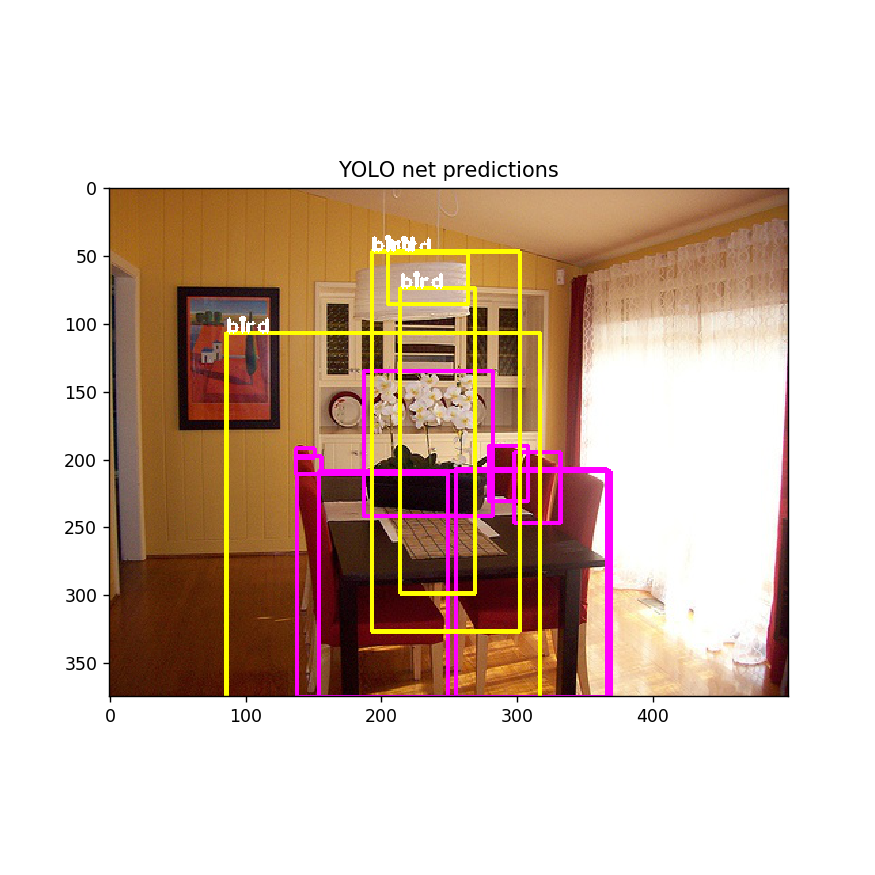

Text(0.5, 1.0, 'YOLO net predictions')

In [10]:
fig1, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax1.set_title("YOLO net predictions")

<IPython.core.display.Javascript object>


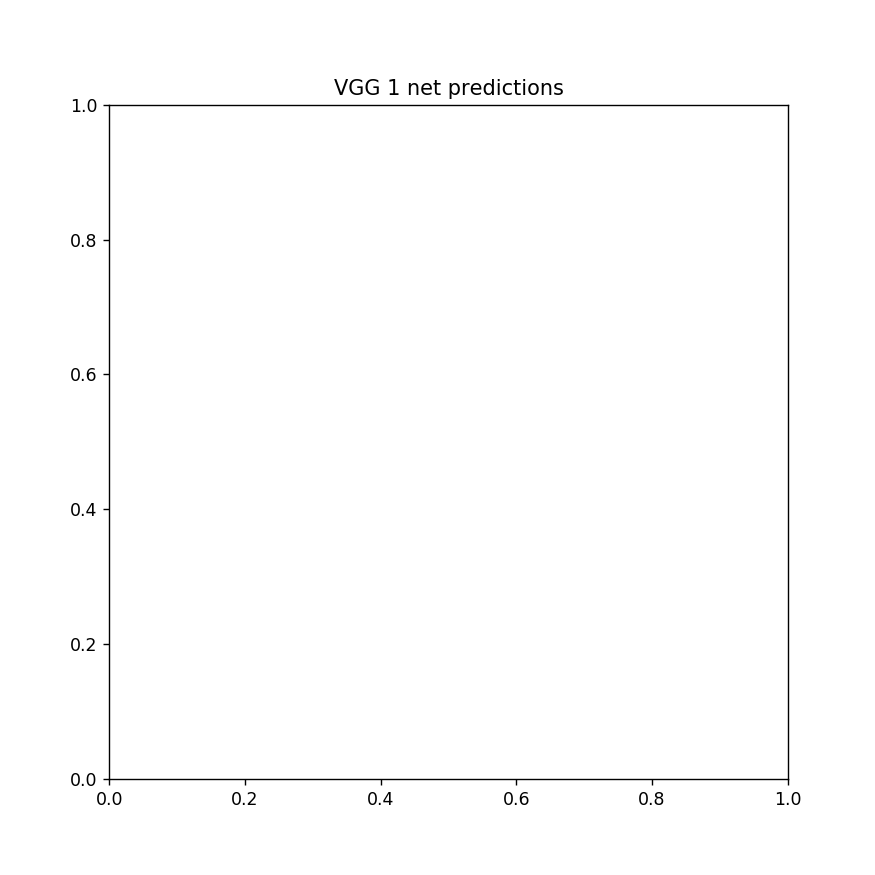

Text(0.5, 1.0, 'VGG 1 net predictions')

In [14]:
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax2.set_title("VGG 1 net predictions")

<IPython.core.display.Javascript object>


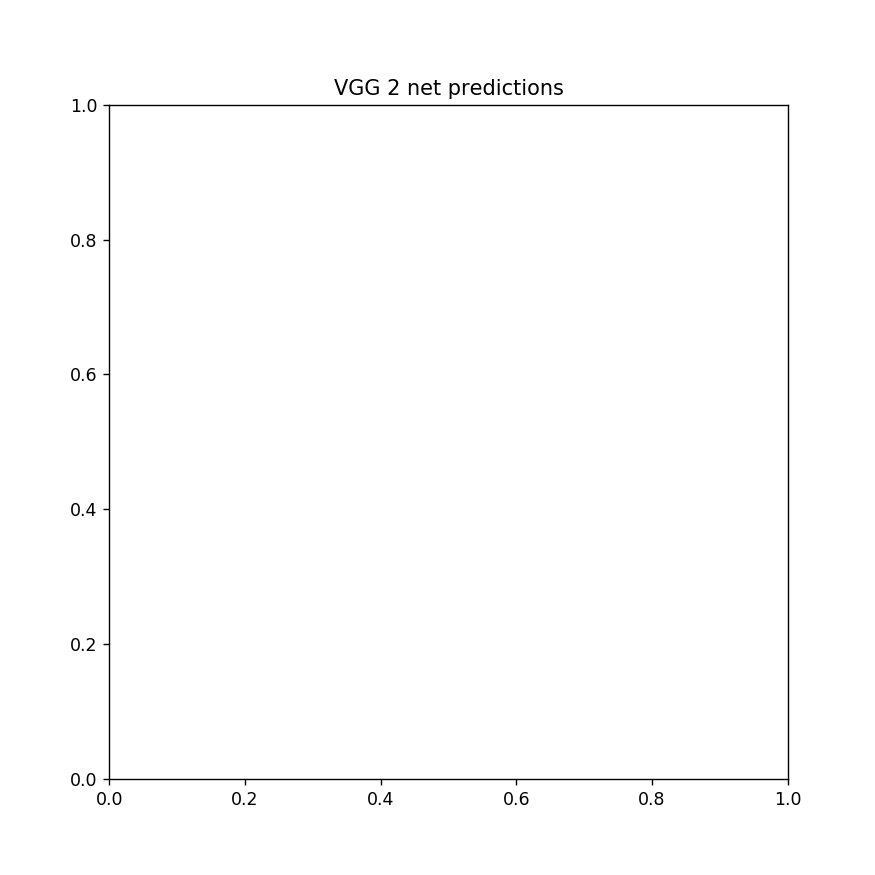

Text(0.5, 1.0, 'VGG 2 net predictions')

In [54]:
fig3, ax3 = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax3.set_title("VGG 2 net predictions")

In [16]:
img_vgg = imread('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg')
h,w,_=img_vgg.shape

for i in range(len(bbox_gt)):
    cv2.rectangle(img_vgg,(bbox_gt[i][0]*w,bbox_gt[i][1]*h),(bbox_gt[i][2]*w,bbox_gt[i][3]*h),[255,0,255],2)
    
for a1,a2,a3,a4 in bbox_vgg:
    i = 0
    cv2.rectangle(img_vgg,(a1*w,a2*h),(a3*w,a4*h),[255,255,0],2)
    putText(img_vgg, cls_vgg[i], (a1*w, a2*h), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,255,255), 2)
    i += 1
    
ax1.imshow(img_vgg)
fig1.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


NameError: name 'bbox_vgg' is not defined

In [15]:
img_yolo = imread('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg')
h,w,_=img_yolo.shape

for i in range(len(bbox_gt)):
    cv2.rectangle(img_yolo,(bbox_gt[i][0]*w,bbox_gt[i][1]*h),(bbox_gt[i][2]*w,bbox_gt[i][3]*h),[255,0,255],2)
    
for a1,a2,a3,a4 in bbox_yolo:
    i = 0
    cv2.rectangle(img_yolo,(a1*w,a2*h),(a3*w,a4*h),[255,255,0],2)
    cv2.putText(img_yolo, cls_yolo[i], (a1*w, a2*h), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,255,255), 2)
    i += 1
    
ax1.imshow(img_yolo)
fig1.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [18]:
img_vgg2 = imread('/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2007/JPEGImages/000006.jpg')
h,w,_=img_vgg2.shape

for i in range(len(bbox_gt)):
    cv2.rectangle(img_vgg2,(bbox_gt[i][0]*w,bbox_gt[i][1]*h),(bbox_gt[i][2]*w,bbox_gt[i][3]*h),[255,0,255],2)
    
for a1,a2,a3,a4 in bbox_vgg2:
    i = 0
    cv2.rectangle(img_vgg2,(a1*w,a2*h),(a3*w,a4*h),[255,255,0],2)
    putText(img_vgg2, cls_vgg2[i], (a1*w, a2*h), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,255,255), 2)
    i += 1
    
ax3.imshow(img_vgg2)
fig3.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


NameError: name 'bbox_resnet' is not defined